<a href="https://colab.research.google.com/github/taravatp/roadLane_InstanceSegmentation/blob/main/dataset/dataset_Hnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torch.utils.data import Dataset,DataLoader
import os.path as ops
import numpy as np
import cv2
import json

In [ ]:
class HNet_dataset(Dataset):
  
  def __init__(self,flag):

    self.flag = flag
    if self.flag == 'train':
      self.annotations_json_path = ['/content/drive/MyDrive/Lane_Detection/TUSMIPLE/label_data_0313.json',
                      '/content/drive/MyDrive/Lane_Detection/TUSMIPLE/label_data_0531.json',
                      '/content/drive/MyDrive/Lane_Detection/TUSMIPLE/label_data_0601.json']

      self.image_paths = '/content/drive/MyDrive/Lane_Detection/TUSMIPLE/txt_for_local/train.txt'
    else: #path for test files
      self.annotations_json_path = ''
      self.image_paths = ''

 
    self.gt_points = self.get_gt_points(self.annotations_json_path)
    self.img_pathes = self.get_image_pathes(self.image_paths)
    self.resize = (128,64)
  
  #def collate_fn(self,batch): #because data loader has to stack tensors of equal sizes
   # return list(zip(*batch))

  def get_gt_points(self,json_files):
    gt_points_list = []
    for json_file in json_files:
      with open(json_file,'r') as file:
        for line in file:

          info_dict = json.loads(line)
          h_samples = info_dict['h_samples']
          lanes = info_dict['lanes']
          raw_file = info_dict['raw_file']
          lane_points = []

          for lane in lanes:
            assert len(h_samples) == len(lane)
            for x,y in zip(lane,h_samples):
              if x == -2:
                continue
              lane_points.append([x,y,1])#
            if not lane_points:
              continue
          gt_points_list.append(lane_points)
    gt_points_list = gt_points_list[0:int(0.8*len(gt_points_list))] #just need the first 80%: the training part
    return gt_points_list

  def get_image_pathes(self,file_open):
    list_image_pathes = []
    with open(file_open, 'r') as file:
          data = file.readlines()
          for l in data:
              line = l.split()
              list_image_pathes.append(line[0]) #we just need the original image not its labels
    return list_image_pathes; 

  def __len__(self):
    return len(self.img_pathes)


  def __getitem__(self, idx):

      gt_image = cv2.imread(self.img_pathes[idx], cv2.IMREAD_UNCHANGED) #reading
      orig = gt_image
      gt_image = cv2.resize(gt_image, dsize=self.resize, interpolation=cv2.INTER_LINEAR) #resizing
      gt_image = gt_image / 127.5 - 1.0 #scaling
      gt_image = np.transpose(gt_image, (2, 0, 1))#channels should come first 
      gt_image = torch.tensor(gt_image, dtype=torch.float) #convert numpy arrays to pytorch tensors

      gt_pts = self.gt_points[idx]
      gt_pts = np.array(gt_pts).reshape((-1, 3))
      for i in range(gt_pts.shape[0]): #we had annotations for 1280×720 images - now we fixed the annotations for 128×64 images
        gt_pts[i][0] =  gt_pts[i][0] * (512. / 1280.) * 0.25
        gt_pts[i][1] =  gt_pts[i][1] * (256. / 720.) * 0.25
      gt_pts = torch.from_numpy(gt_pts)
      
      return gt_image, gt_pts


# Experiment

In [ ]:
test = HNet_dataset('train')

In [ ]:
gt_image , gt_pts = test[2300]

In [ ]:
gt_image = gt_image.numpy()
gt_image = np.transpose(gt_image,(1,2,0))
gt_image = (gt_image+1) * 127.5
gt_image = gt_image.astype('uint8')
gt_image = cv2.cvtColor(gt_image, cv2.COLOR_RGB2BGR)

In [ ]:
gt_pts = gt_pts.numpy()

In [ ]:
annotations = np.array(gt_image,copy=True)
for i in range(gt_pts.shape[0]):
  annotations = cv2.circle(annotations,(gt_pts[i][0],gt_pts[i][1]),1,(0,255,0),1)

Text(0.5, 1.0, 'original image with annotations')

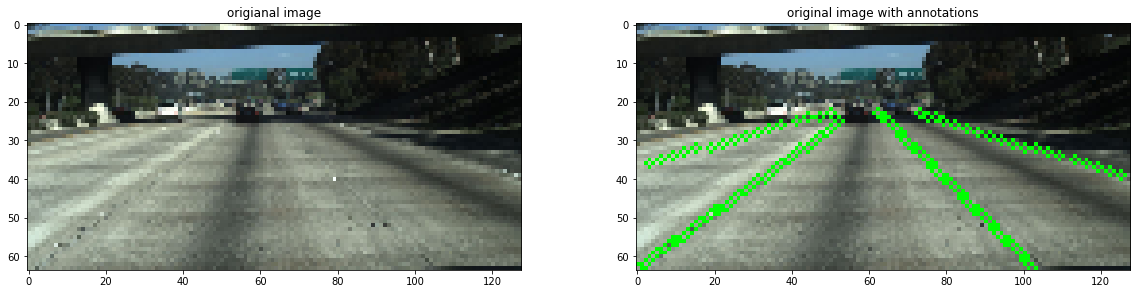

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))

ax1 = plt.subplot(221)
plt.imshow(gt_image)
plt.title('origianal image')

ax1 = plt.subplot(222)
plt.imshow(annotations)
plt.title('original image with annotations')

#noghte ha ro neshoon nemide chon size e original image motefavet ast! agar mikhai bebini original image ro ret kon